## 数据处理

### 英文情感分析

In [1]:
import pandas as pd 
import os
## data with imdb-movie
## https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis
basepath = ""
movie_path = basepath + "movie.csv"
movie_df = pd.read_csv(movie_path)
movie_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [2]:
#after data downloaded
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import string
import collections
import matplotlib.pyplot as plt

def read_imdb(data_dir, train):
    """读取IMDb评论数据集文本序列和标签"""
    """分别读取训练集与测试集"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if train else 'test', label)
        print(folder_name)
        for file in os.listdir(folder_name):
          with open(os.path.join(folder_name, file), 'rb') as f:
              review = f.read().decode('utf-8').replace('\n', '')
              data.append(review)
              labels.append(1 if label == 'pos' else 0)
    return data, labels

#使用类的方式避免重复运算
class Vocab:
    #min_freq：把出现次数少于min_freq的低频率词元视为相同的未知词元视为'<unk>'
    def __init__(self, tokens=[], min_freq=0):
        # 展开多维的token列表
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # 计算token中对应数据的出现次数，从大到小
        counter = collections.Counter(tokens)
        self.freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.index_to_token = sorted([token for token, freq in self.freqs 
                                      if freq >= min_freq]) + ['<unk>']
        self.token_to_index = {token: idx
                             for idx, token in enumerate(self.index_to_token)}
        
    def __len__(self):
        return len(self.index_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # if not exist '<unk>'
            return self.token_to_index.get(tokens, self.token_to_index['<unk>'])
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if isinstance(indices, list):
            return [self.index_to_token[int(index)] for index in indices]
        return self.index_to_token[indices]
    def idx_to_token(self, indices):
        return self.to_tokens(indices)

def token_nize(sentence_list):
  wordss = []
  for s in sentence_list:
    words = s.split(" ")
    words = [w.strip(string.punctuation) for w in words]
    wordss.append(words)
  return wordss

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器。"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

def config_data(batch_size = 0, num_steps=500):
    # imdb_data_process
    imdb_data_dir = "aclImdb"
    imdb_train_data = read_imdb(imdb_data_dir, True)
    imdb_train = pd.DataFrame([imdb_train_data[0], imdb_train_data[1]]).T
    imdb_train.columns = ['sentence','label']
    imdb_test_data = read_imdb(imdb_data_dir, False)
    imdb_test = pd.DataFrame([imdb_test_data[0], imdb_test_data[1]]).T
    imdb_test.columns = ['sentence','label']
    # movie_data_process
    movie_train, movie_test = train_test_split(movie_df, test_size=0.5, random_state=0)
    movie_train.columns = ['sentence','label']
    movie_test.columns = ['sentence','label']
    
    train_data = pd.concat([movie_train, imdb_train])
    test_data = pd.concat([movie_test, imdb_test])
    train_data['label'] = train_data['label'].astype(int)
    test_data['label'] = test_data['label'].astype(int)
    
    train_tokens = token_nize(train_data["sentence"])
    test_tokens = token_nize(test_data["sentence"])
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    return train_features, test_features, train_data, test_data, vocab

train_features, test_features, train_data, test_data, vocab = config_data()
def load_data(batch_size, num_steps=500):
    train_iter = load_array((train_features, torch.tensor(train_data["label"].values)), batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data["label"].values)), batch_size, is_train=False)
    return train_iter, test_iter, vocab

aclImdb/train/pos
aclImdb/train/neg
aclImdb/test/pos
aclImdb/test/neg


## 构建数据迭代器

In [3]:
from torch import nn
batch_size = 64
train_iter, test_iter, vocab = load_data(batch_size)

In [4]:
print(train_iter, test_iter, vocab)

<torch.utils.data.dataloader.DataLoader object at 0x7fc499361280> <torch.utils.data.dataloader.DataLoader object at 0x7fc4993085b0> <__main__.Vocab object at 0x7fc4e44ae280>


## 构建模型
#### (小组设计)

In [5]:
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        # 定义嵌入层（embedding layer），用于将输入数据中的每个单词映射到一个固定大小的向量（embed_size）。这里使用了nn.Embedding类来实现，其输入参数为词汇表大小（vocab_size）和嵌入向量的维度（embed_size）
        super(SentimentAnalysisLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 定义LSTM层（nn.LSTM）。接受嵌入层的输出作为输入，通过num_hiddens参数指定了LSTM隐藏层的维度，num_layers参数用于指定LSTM层的数量，以增加模型的复杂度和表达能力
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=num_hiddens, num_layers=num_layers)
        # 定义线性层（nn.Linear），将LSTM的最后一个时间步的隐藏状态（即encoding）作为输入，并输出模型的最终预测结果。该线性层的输出维度为2，因为情感分析任务是一个二分类问题
        self.decoder = nn.Linear(num_hiddens, 2)
        
    def forward(self, inputs):
        # 通过嵌入层将输入数据转换为嵌入向量，并对其进行了转置（permute）操作，以便与LSTM层的输入格式相匹配
        embeddings = self.embedding(inputs.permute(1, 0))
        # 进行处理
        outputs, _ = self.encoder(embeddings)
        # LSTM层的输出是一个三维张量，其中第一维表示时间步，第二维表示批次，第三维表示隐藏状态的维度
        encoding = outputs[-1]
        # 取输出的最后一个时间步（即outputs[-1]）的隐藏状态作为最终的表示（encoding）。最后，将该表示作为输入传递给线性层，生成最终的情感分析预测结果
        outs = self.decoder(encoding)
        return outs
vocab_size = len(vocab)
embed_size = 100
num_hiddens = 100
num_layers = 2
net = SentimentAnalysisLSTM(vocab_size, embed_size, num_hiddens, num_layers)

In [6]:

# 损失函数：计算模型预测值和实际值之间的差异
loss = nn.CrossEntropyLoss()
# 定义优化器optimizer，用于更新模型参数以最小化损失函数
# 使用了Adam优化算法，学习率为0.001
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def evaluate_accuracy(data_iter, net):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().cpu().item()
            n += y.shape[0]
    return acc_sum / n

def train(net, train_iter, test_iter, loss, optimizer, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    print("training on", device)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            # 预测结果
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            l.backward()
            # 更新参数
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_iter, test_iter, vocab = load_data(batch_size)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc))


In [7]:

num_epochs = 10
train(net, train_iter, test_iter, loss, optimizer, num_epochs)
print(train_iter)

training on cuda
epoch 1, loss 0.6928, train acc 0.508, test acc 0.502
epoch 2, loss 0.6841, train acc 0.516, test acc 0.518
epoch 3, loss 0.6649, train acc 0.527, test acc 0.516
epoch 4, loss 0.6478, train acc 0.537, test acc 0.524
epoch 5, loss 0.6387, train acc 0.551, test acc 0.638
epoch 6, loss 0.5236, train acc 0.746, test acc 0.786
epoch 7, loss 0.3573, train acc 0.855, test acc 0.855
epoch 8, loss 0.2435, train acc 0.910, test acc 0.874
epoch 9, loss 0.1657, train acc 0.944, test acc 0.891
epoch 10, loss 0.1161, train acc 0.965, test acc 0.902


In [8]:
torch.save(net.state_dict(), 'sentiment_analysis_lstm.pt')

In [9]:
def predict_sentence(model, vocab, sentence):
    num_steps = 500
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sentence = token_nize([sentence])
    sentence_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in sentence])
    sentence_iter = load_array((sentence_features, torch.tensor([0])), batch_size, is_train=False)
    for X, y in sentence_iter:
        X = X.to(device)
        output = model(X)
        prediction = torch.argmax(output, dim=1)
        label = prediction[0].item()
    print("predict: ", "positive" if label == 1 else "negative")

In [10]:
predict_sentence(net, vocab, "this is bad")

predict:  negative


#### d2l

In [11]:
from d2l import torch as d2l

train_iter, test_iter, vocab = load_data(batch_size)
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(50846, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [12]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [13]:
embeds = glove_embedding[[vocab.idx_to_token(i) for i in range(len(vocab))]]
embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.092, train acc 0.969, test acc 0.924
2442.2 examples/sec on [device(type='cuda', index=0)]


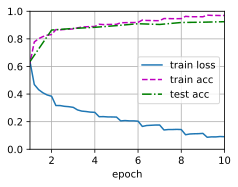

In [14]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

In [15]:
#@save
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    print('predict:', 'positive' if label == 1 else 'negative')

In [16]:
predict_sentiment(net, vocab, "this is bad")
predict_sentence(net, vocab, "this is bad")

predict: negative
predict:  negative
